# OHP Air Transparency for a pure molecular scattering sky
=====================================================================================

Compare with analytical model with LibRadTran model
------------------------------------------------
- author Sylvie Dagoret-Campagne
- Affilifation : LAL/IN2P3/CNRS
- creation date May 3rd 2017


The purpose is to compare the air transparency for pure molecular scattering (Rayleigh)
For the three models at OHP : US standard atmosphere (us), mid lattitude winter (mw), mid lattitude summer (ms)

In [25]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
import pandas as pd
import os
import re

In [27]:
from astropy.constants import N_A,R,g0
from astropy import units as u

In [28]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Analytical models

## Constants

In [29]:
M_air= 28.965338*u.g/u.mol
M_air_dry=28.9644*u.g/u.mol
M_h2o=18.016*u.g/u.mol
P0=101325.*u.Pa;   # /*!< Pa : pressure at see level */
T0=288.15*u.K;   #/*!< sea level temperature */  
L=0.0065*u.K/u.m  # refroidissement en fonction de l'altitude

## Functions

### Pressure model

Non adiabatic model : T depends on altitude:
$$
T = T_0 - L h 
$$

The pressure at altitude  $h$ is given by:
$$
   p = p_0 \left(1 - \frac{L h}{T_0} \right)^\frac{g M}{R L}
$$

In [30]:
def Pressure(h):
    P=P0*np.exp(g0*M_air_dry/R/L*np.log(1-L*h/T0))
    return P

###  the atmospheric column depth $X$:
\begin{equation}
X(h,\theta)= P(h)/\cos \theta
\end{equation}



In [31]:
def XDepth(altitude,costh=1):
    """
    Function : XDepth(altitude,costh)
      Provide the column depth in gr / cm^2 equivalent of airmass in physical units
    - Input :  altitude : input altitude in meters
    - Input :  costh    : input cosimus of zenith angle 
    - Output :  XDepth  : output column depth in gr per cm squared
    """
    h=altitude
    XD=Pressure(h)/g0/costh
    return XD

### Optical Depth for Rayleigh scattering : first formula

$$
\delta_{rayl} = \frac{X(h,\theta)}{3102 g/cm^2 } \left( \frac{400 nm}{\lambda}\right)^4  \frac{1}{ 1-0.0722\left(\frac{400nm}{\lambda}\right)^2} 
$$


In [32]:
def RayOptDepth(wavelength, altitude=0*u.m, costh=1):
    """
    Function RayOptDepth(double wavelength, double altitude, double costh)

    Provide Rayleigh optical depth
         
    - Input  wavelength : input wavelength in nm
    - Input  altitude : input altitude in meters
    - Input   costh    : input cosimus of zenith angle 
    - Output  OptDepth  : output optical depth no unit, for Rayleigh
    """

    h=altitude

    A=(XDepth(h,costh)/(3102.*u.g/(u.cm*u.cm)))
    B=np.exp(-4.*np.log(wavelength/(400.*u.nm)))  
    C= 1-0.0722*np.exp(-2*np.log(wavelength/(400.*u.nm)))

    OD=A*B/C
        
    #double OD=XDepth(altitude,costh)/2970.*np.power((wavelength/400.),-4);

    return OD

### Optical Depth for Rayleigh scattering : second formula

$$
\delta_{rayl} =  \frac{X(h,\theta)}{2770 g/cm^2 } \left( \frac{400 nm}{\lambda}\right)^4 
$$



In [33]:
def RayOptDepth2(wavelength, altitude=0*u.m, costh=1):
    """
    Function RayOptDepth2(wavelength, altitude, costh)

    Provide Rayleigh optical depth
    - Input wavelength : input wavelength in nm
    - Input altitude : input altitude in meters
    - Input costh    : input cosimus of zenith angle 
    - Output OptDepth  : optical depth no unit
    
    """
    h=altitude
    A=XDepth(h,costh)/(2770.*u.g/(u.cm*u.cm))
    B=np.exp(-4*np.log(wavelength/(400.*u.nm)))
    OD=A*B         
  
    return OD

In [46]:
wavelength=np.linspace(200.,1100.,100)*u.nm
cos_theta=1
altitude0=650*u.m

In [48]:
RAOD1=RayOptDepth(wavelength, altitude=altitude0, costh=cos_theta)
RAOD2=RayOptDepth2(wavelength, altitude=altitude0, costh=cos_theta)

In [52]:
T1=np.exp(-RAOD1)
T2=np.exp(-RAOD2)

### Defines where the LibRadTran files are

In [34]:
currentpath=os.getcwd()
rootpath_us='../simulations/RT/2.0.1/OH/pp/us/sc/out'
rootpath_mw='../simulations/RT/2.0.1/OH/pp/mw/sc/out'
rootpath_ms='../simulations/RT/2.0.1/OH/pp/ms/sc/out'

### Build the list of the files

In [35]:
filelist_us=os.listdir(rootpath_us) 
filelist_mw=os.listdir(rootpath_mw) 
filelist_ms=os.listdir(rootpath_ms) 

### Make a sublist of the files for sky afglmw

In [36]:
filelist_afglmw= []
for filename in filelist_mw:
    if re.search('z10',filename):  #example of filename filter
        filelist_afglmw.append(filename)

In [37]:
filelist_afglms= []
for filename in filelist_ms:
    if re.search('z10',filename):  #example of filename filter
        filelist_afglms.append(filename)

### Make a sublist of the files for sky afglus

In [38]:
filelist_afglus= []
for filename in filelist_us:
    if re.search('z10',filename): #example of filename filter
        filelist_afglus.append(filename)

### Show the air transparences for sky afglmw

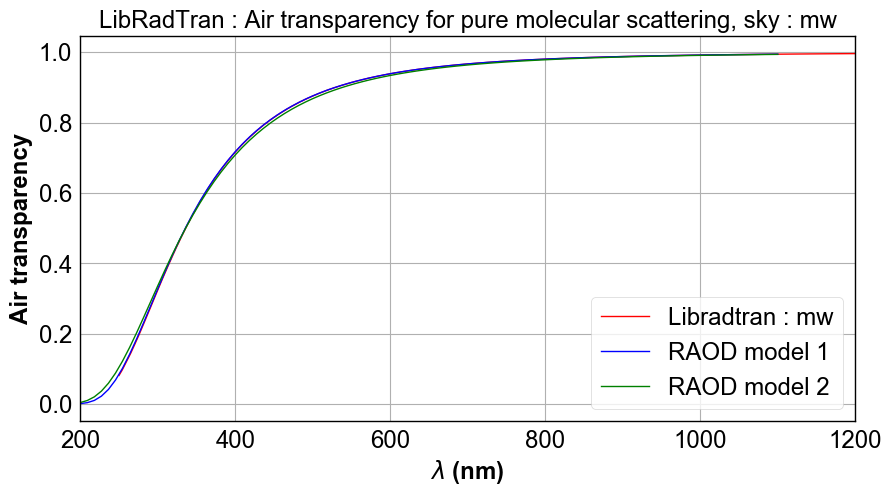

In [63]:
for filename in filelist_afglmw:
    fullpath=os.path.join(rootpath_mw,filename)
    data = np.loadtxt(fullpath)
    x=data[:,0]
    y=data[:,1]
    plt.plot(x,y,'r',label='Libradtran : mw')  
    plt.plot(wavelength,T1,'b',label='RAOD model 1')
    plt.plot(wavelength,T2,'g',label='RAOD model 2' )
plt.xlim(200,1200)
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Air transparency')   
plt.title('LibRadTran : Air transparency for pure molecular scattering, sky : mw')
plt.legend()

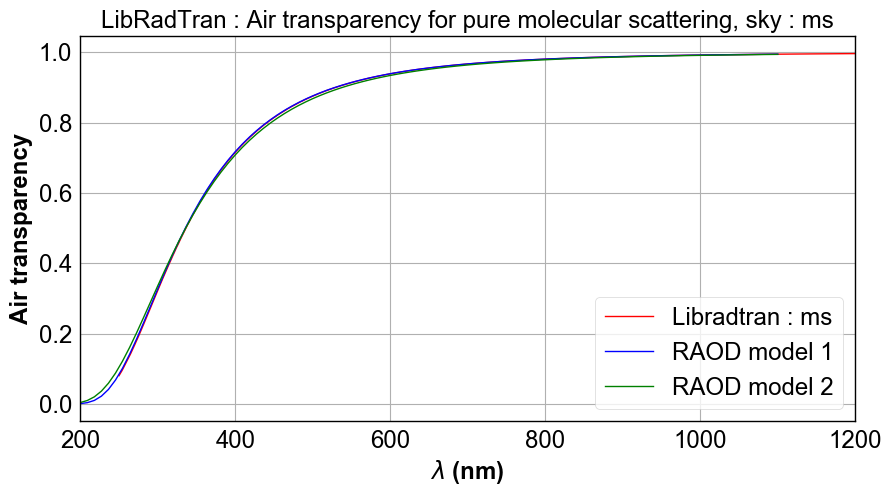

In [62]:
for filename in filelist_afglms:
    fullpath=os.path.join(rootpath_ms,filename)
    data = np.loadtxt(fullpath)
    x=data[:,0]
    y=data[:,1]
    plt.plot(x,y,'r',label='Libradtran : ms')  
    plt.plot(wavelength,T1,'b',label='RAOD model 1')
    plt.plot(wavelength,T2,'g',label='RAOD model 2' )
plt.xlim(200,1200)
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Air transparency')   
plt.title('LibRadTran : Air transparency for pure molecular scattering, sky : ms')
plt.legend()

### Show the air transparences for sky afglus

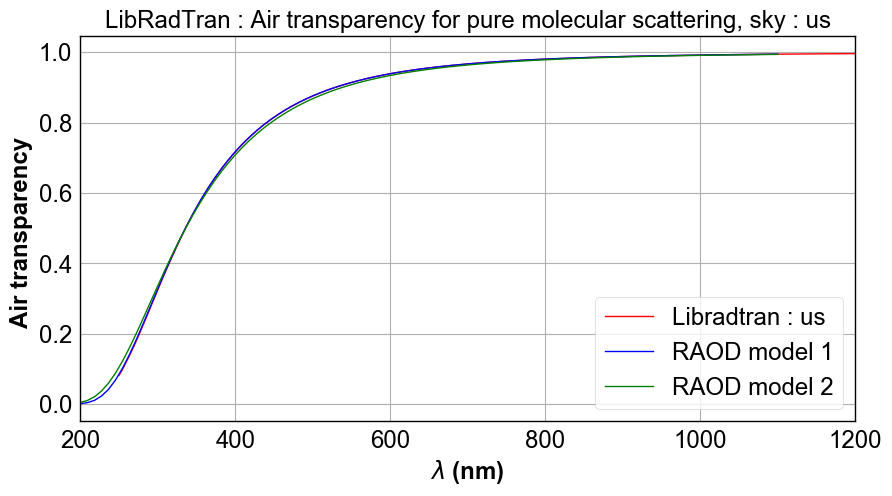

In [61]:
for filename in filelist_afglus:
    fullpath=os.path.join(rootpath_us,filename)
    data = np.loadtxt(fullpath)
    x=data[:,0]
    y=data[:,1]
    plt.plot(x,y,'r',label='Libradtran : us')  
    plt.plot(wavelength,T1,'b',label='RAOD model 1')
    plt.plot(wavelength,T2,'g',label='RAOD model 2' )
    
plt.xlim(200,1200)
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Air transparency ')   
plt.title('LibRadTran : Air transparency for pure molecular scattering, sky : us')
plt.legend()

## Conclusion

The analytical model of Rayleigh scattering, especially the first one, describes wery well the Rayleigh scattering in LibRadTran, for US, MW,MS.
Thus this analytical model can be used for horizontal Rayleigh scattering